!!! note

    This example is available as a jupyter notebook [here](https://github.com/SimiPixel/ring/blob/main/docs/notebooks/knee_angle_tracking.ipynb).

    And on Google Colab [here](https://colab.research.google.com/github/SimiPixel/ring/blob/main/docs/notebooks/knee_angle_tracking.ipynb)

Setup the environment if this is executed on Google Colab.

*Make sure to change the runtime type to `GPU`. To do this go to `Runtime` -> `Change runtime type` -> `GPU`*

Otherwise, rendering won't work in Google Colab.

In [1]:
import os

try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    os.system("pip install -q imt-ring")
    os.system("pip install -q matplotlib")


In [2]:
import ring
# automatically detects colab or not
ring.utils.setup_colab_env()

import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

import mediapy as media

In [38]:
sys_str = """
<x_xy model="knee">
    <options gravity="0 0 9.81" dt="0.01"/>
    <worldbody>
        <body name="femur" joint="frozen" pos="0 0 0.5" euler="0 0 140">
            <geom type="xyz" dim="0.1"/>
            <geom type="capsule" mass="1" pos="0 0 -0.2" dim="0.05 0.4"/>
            <body name="imu_femur" joint="frozen" pos="0 .06 -.2" pos_min="-.05 0 -.3" pos_max=".05 .08 -.1">
                <geom type="xyz" dim="0.05"/>
                <geom type="box" mass="0.1" dim="0.05 0.02 0.05" color="orange"/>
            </body>
            <body name="tibia" joint="rx" pos="0 0 -0.4" damping="3">
                <geom type="xyz" dim="0.1"/>
                <geom type="capsule" mass="1" pos="0 0 -0.2" dim="0.04 0.4"/>
                <geom type="box" mass="0.1" pos="0 0.04 -0.45" dim="0.05 0.15 0.025"/>
                <body name="imu_tibia" joint="frozen" pos="0 0.05 -0.2" pos_min="-.05 0 -.3" pos_max=".05 .07 -.1">
                    <geom type="xyz" dim="0.05"/>
                    <geom type="box" mass="0.1" dim="0.05 0.02 0.05" color="orange"/>
                </body>
            </body>
        </body>
    </worldbody>
</x_xy>
"""  # noqa: E501

Rendering frames..: 100%|██████████| 1/1 [00:00<00:00, 21.78it/s]


""

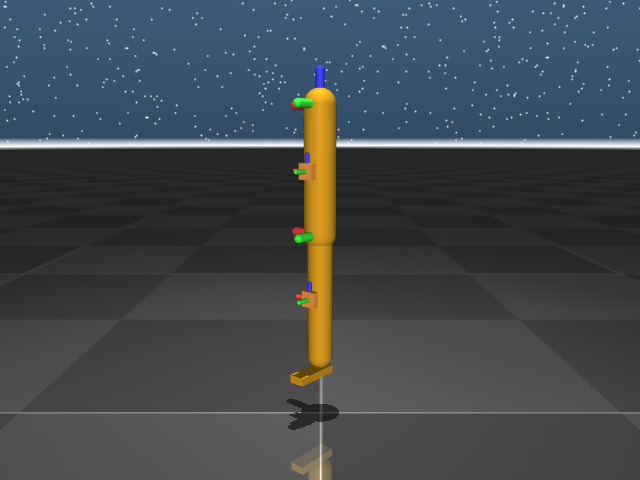

In [39]:
sys = ring.System.create(sys_str)
media.show_image(sys.render(width=640, height=480, camera="custom", add_cameras = {-1:'<camera pos="0 -1.8 0.4" mode="fixed" euler="80 0 0" name="custom"/>'})[0])

In [40]:
(X, _), (_, qs, xs, _) = ring.RCMG(sys, ring.MotionConfig(T=20.0, t_min=0.3, t_max=1.5), keep_output_extras=1, add_X_imus=1).to_list()[0]

eager data generation: 1it [00:01,  1.29s/it]


In [41]:
media.show_video(sys.render(xs, width=640, height=480, camera="custom", 
                            add_cameras = {-1:'<camera pos="0 -1.8 0.4" mode="fixed" euler="80 0 0" name="custom"/>'}, render_every_nth=4), fps=25)

Rendering frames..: 100%|██████████| 500/500 [00:04<00:00, 101.41it/s]


In [43]:
X.keys()

dict_keys(['femur', 'tibia'])

In [44]:
X["femur"].keys()

dict_keys(['acc', 'gyr'])

In [67]:
ringnet = ring.ml.RING_ICML24()

# number of timesteps
T = 2000
# graph
lam = (-1, 0)
# number of bodies (excluding IMUs); so tibia and femur
N = len(lam)

X_ring = np.zeros((T, N, 10))

X_ring[:, 0, :3] = X["femur"]["acc"]
X_ring[:, 0, 3:6] = X["femur"]["gyr"]
X_ring[:, 1, :3] = X["tibia"]["acc"]
X_ring[:, 1, 3:6] = X["tibia"]["gyr"]

# time-delta between timesteps or inverse of sampling rate
X_ring[:, :, 9] = float(sys.dt)

# We could assume that we don't know the hinge joint axis direction
KNOWN_JOINT_AXIS = True
if KNOWN_JOINT_AXIS:
    # the components 6:9 store the axis direction; here it is rx-joint; Revolute x-axis
    X_ring[:, 1, 6] = 1.0

quaternions, _ = ringnet.apply(X_ring, lam=lam)

Detected the following sampling rates from `X`: 100.0


In [68]:
quaternions.shape

# quaternions[:, 0]
# inclination: orientation from femur to earth
# quaternioins[:, 1]
# orientation from tibia to femur

(2000, 2, 4)

Text(0, 0.5, 'Knee Angle [rad]')

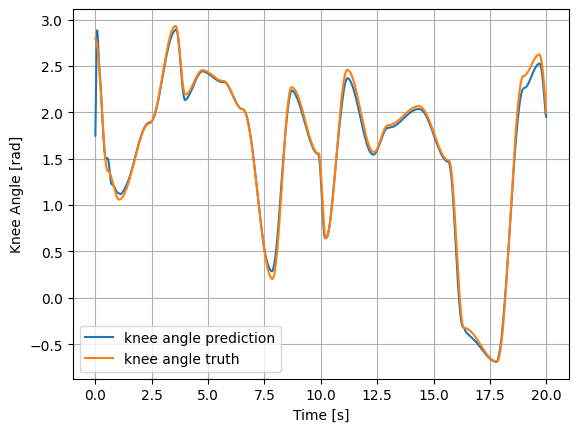

In [70]:
ts = np.arange(0, 20.0, step=sys.dt)
plt.plot(ts, ring.maths.quat_angle_constantAxisOverTime(quaternions[:, 1]), label="knee angle prediction")
plt.plot(ts, -qs, label="knee angle truth")
plt.grid()
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Knee Angle [rad]")